In [1]:
using PyPlot

INFO: Loading help data...


In [18]:
function draw_arrow(i::Int64, j::Int64, action::Symbol, dim::(Int64, Int64), changed::Bool)
    NX = dim[2]
    NY = dim[1]+1
    offset = 0.1
    if action == :north
        arrow(i-0.5, NY-j-0.9, 0, +0.3, 0, head_width=0.5, head_length=0.5, lw=1, edgecolor="black", facecolor = (changed?"red":"blue"))
    elseif action == :south
        arrow(i-0.5, NY-j-0.1, 0, -0.3, 0, head_width=0.5, head_length=0.5, lw=1, edgecolor="black", facecolor = (changed?"red":"blue"))
    elseif action == :east
        arrow(i-0.9, NY-j-0.5, +0.3, 0, head_width=0.5, head_length=0.5, lw=1, edgecolor="black", facecolor = (changed?"red":"blue"))
    elseif action == :west
        arrow(i-0.1, NY-j-0.5, -0.3, 0, head_width=0.5, head_length=0.5, lw=1, edgecolor="black", facecolor = (changed?"red":"blue"))
    end
end

function plot_data(maze::Matrix{Char}, policy::Matrix{Symbol}, V::Matrix{Float64}, old_policy::Any)
    s = (size(V)[2]*0.6, size(V)[1] .* 0.25)
    figure(figsize=s)
    subplot(121)
    xticks([])
    yticks([])
    xlim([1,size(V)[2]-1])
    ylim([1,size(V)[1]-1])

    for i = 1:size(V)[2]-2
        plot([i,i],[0,size(V)[1]], color="black")
    end
    for i = 1:size(V)[1]-2
        plot([0,size(V)[2]], [i,i], color="black")
    end
    
    for i = 2:size(V)[1]-1
        for j = 2:size(V)[2]-1
            changed = false
            if old_policy != nothing
                changed = (policy[i, j] != old_policy[i,j])
            end
            draw_arrow(j, i, policy[i, j], size(V), changed)
            #draw_arrow(j, i, :west, size(V))
        end
    end
    subplot(122)
    colorbar(imshow(V[2:end-1,2:end-1], interpolation="none"))
    xticks([])
    yticks([])
    c_values = [v>-100?v:0 for v in V]
    clim([minimum(c_values),maximum(c_values)])
end

plot_data (generic function with 1 method)

In [23]:
function convert_string_to_string_array(s::String)
    index = 1
    while s[index] == ' ' || s[index] == '\n'
        index = index + 1
    end
    maze = nothing
    row = []
    for i=index:length(s)
        if s[i] == '\n'
            if maze == nothing
                maze = row
            else
                maze = hcat(maze, row)
            end
            row = []
        else
            row = [row, s[i]]
        end
    end
    return maze'
end

function create_experiment_setup(definition::String)
    actions = [:north, :east, :south, :west, :none]

    maze   = convert_string_to_string_array(maze_definition)
    V      = zeros(size(maze))
    n      = zeros(size(maze))
    C      = zeros(size(maze))
    policy = reshape([actions[int64(ceil(rand() * (length(actions)-1)))] for i = 1:length(maze)], size(maze))

    for i=1:length(maze)
        if maze[i] in ['#', 'T']
            V[i] = state_reward_function[maze[i]]
            policy[i] = :none
        end
    end

    return maze, policy, V, n, C
end

create_experiment_setup (generic function with 1 method)

In [24]:
function policy_iteration!(maze::Matrix{Char}, policy::Matrix{Symbol}, V::Matrix{Float64})
    old_policy = copy(policy)
    for i = 2:size(maze)[1]-1
        for j = 2:size(maze)[2]-1
            if maze[i,j] == ' '
                possible_actions = []
                action_values = []
                if maze[i-1,j] != '#'
                    possible_actions = [possible_actions, :north]
                    action_values    = [action_values, V[i-1, j]]
                end
                if maze[i+1,j] != '#'
                    possible_actions = [possible_actions, :south]
                    action_values    = [action_values, V[i+1, j]]
                end

                if maze[i,j-1] != '#'
                    possible_actions = [possible_actions, :west]
                    action_values    = [action_values, V[i, j-1]]
                end
                if maze[i,j+1] != '#'
                    possible_actions = [possible_actions, :east]
                    action_values    = [action_values, V[i, j+1]]
                end
                best_action_value = maximum(action_values)
                possible_actions = possible_actions[findin(action_values,best_action_value)]
                action = possible_actions[int(ceil(rand() * length(possible_actions)))] # random
                policy[i,j] = action
            end
        end
    end
    plot_data(maze, policy, V, old_policy)
end

policy_iteration! (generic function with 1 method)

In [51]:
function policy_evaluation!(maze::Matrix{Char}, policy::Matrix{Symbol}, state_reward_function::Dict{Char, Float64}, V::Matrix{Float64}, C::Matrix{Float64}, n::Matrix{Float64}, T::Int64, R::Int64)
    
    for i = 2:size(V)[1] - 1
        for j = 2:size(V)[2] - 1
            if maze[i,j] != ' '
                V[i,j] = state_reward_function[maze[i,j]]
            end
        end
    end
    
    for i = 1:R
    # randomise start position
    x = 1 + int64(ceil(rand() * size(V)[1])) - 1
    y = 1 + int64(ceil(rand() * size(V)[2])) - 1
    
    while maze[x,y] != ' '
        x = 1 + int64(ceil(rand() * size(V)[1])) - 1
        y = 1 + int64(ceil(rand() * size(V)[2])) - 1
    end
    
    init_x = x
    init_y = y
    
    for i=1:T
        if policy[x,y] == :north
            if maze[x - 1,y] != '#'
                x = x -1
            end
        elseif policy[x,y] == :south
            if maze[x + 1,y] != '#'
                x = x + 1
            end
        elseif policy[x,y] == :east
            if maze[x,y + 1] != '#'
                y = y + 1
            end
        elseif policy[x,y] == :west
            if maze[x,y - 1] != '#'
                y = y - 1
            end
        end
        C[init_x, init_y] = C[init_x, init_y] + state_reward_function[maze[x,y]]
        n[init_x, init_y] = n[init_x, init_y] + 1.0
    end
    V[init_x, init_y] = C[init_x, init_y] / n[init_x, init_y]
    end
    plot_data(maze, policy, V, policy)
end

policy_evaluation! (generic function with 5 methods)

### Evaluation

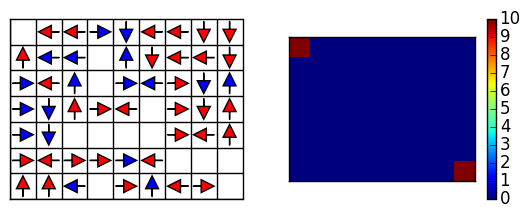

10

In [117]:
maze_definition = "
###########
#T        #
#   #     #
#   #     #
#     #   #
#  ####   #
#      ####
#   #    T#
###########
"

state_reward_function = ['T' => 10.0, '#' => -100.0, ' ' => 0.0];

maze, policy, V, C, n = create_experiment_setup(maze_definition);

policy_iteration!(maze, policy, V)

T = 1000
N = 10

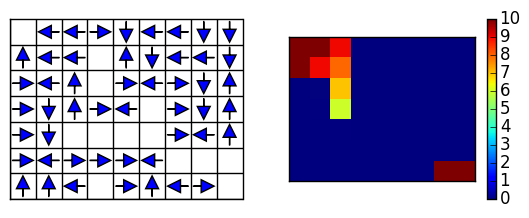

In [118]:
policy_evaluation!(maze, policy, state_reward_function, V, C, n, N, T)

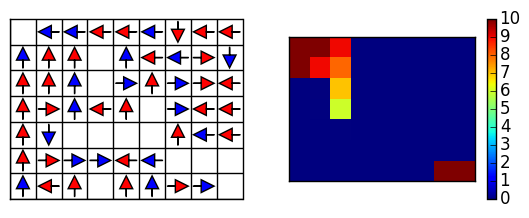

In [119]:
policy_iteration!(maze, policy, V)

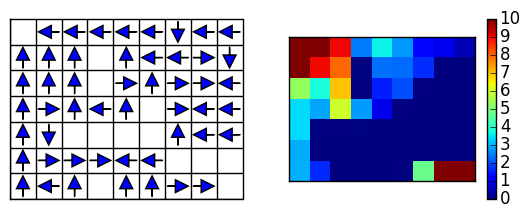

In [120]:
policy_evaluation!(maze, policy, state_reward_function, V, C, n, N, T)

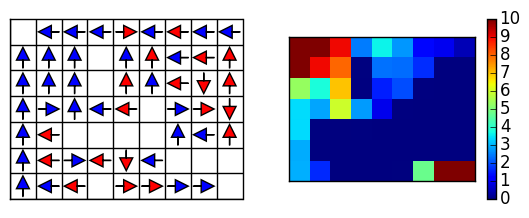

In [121]:
policy_iteration!(maze, policy, V)

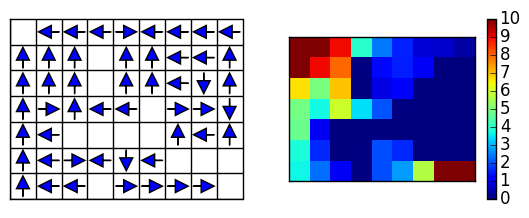

In [122]:
policy_evaluation!(maze, policy, state_reward_function, V, C, n, N, T)

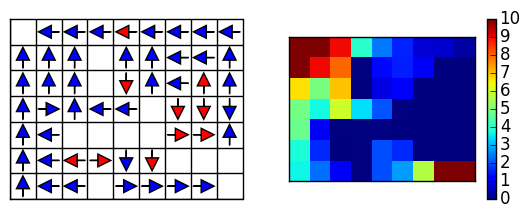

In [123]:
policy_iteration!(maze, policy, V)

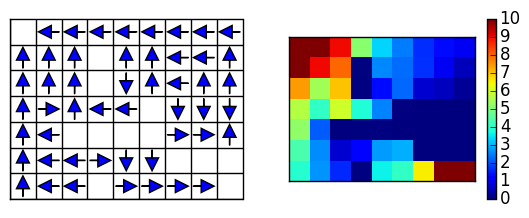

In [124]:
policy_evaluation!(maze, policy, state_reward_function, V, C, n, N, T)

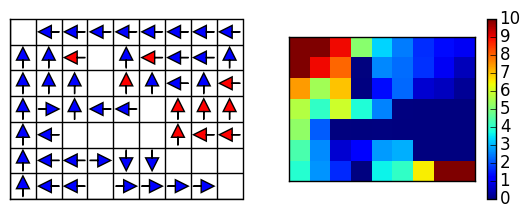

In [125]:
policy_iteration!(maze, policy, V)

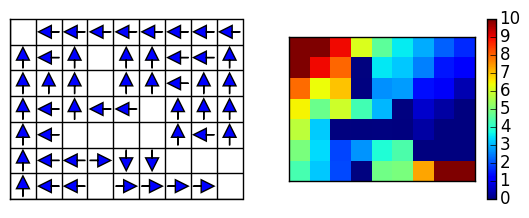

In [128]:
policy_evaluation!(maze, policy, state_reward_function, V, C, n, N, T)

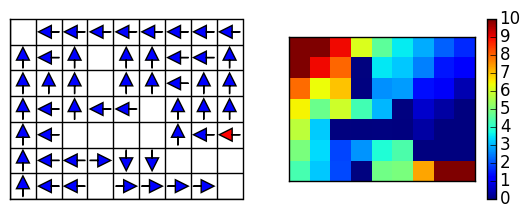

In [129]:
policy_iteration!(maze, policy, V)

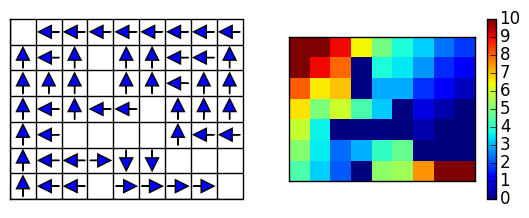

In [130]:
policy_evaluation!(maze, policy, state_reward_function, V, C, n, N, T)

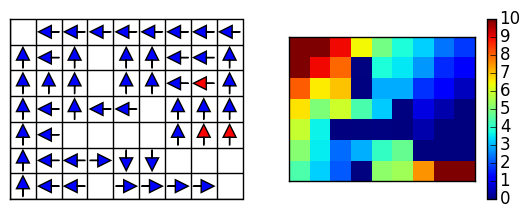

In [131]:
policy_iteration!(maze, policy, V)

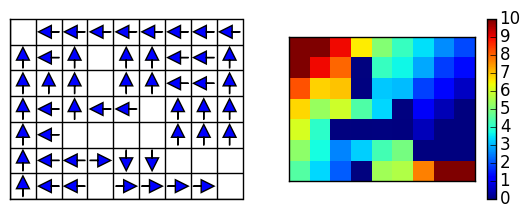

In [132]:
policy_evaluation!(maze, policy, state_reward_function, V, C, n, N, T)

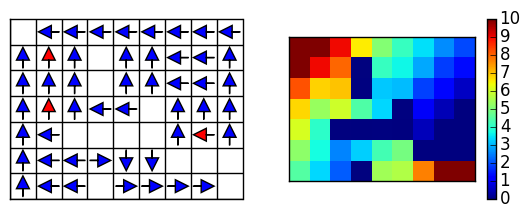

In [133]:
policy_iteration!(maze, policy, V)

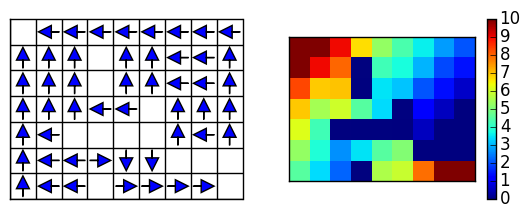

In [134]:
policy_evaluation!(maze, policy, state_reward_function, V, C, n, N, T)

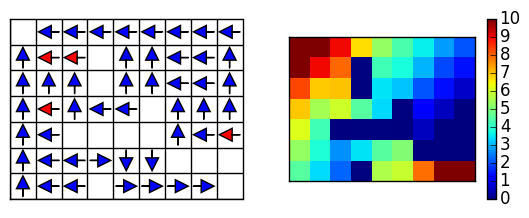

In [135]:
policy_iteration!(maze, policy, V)

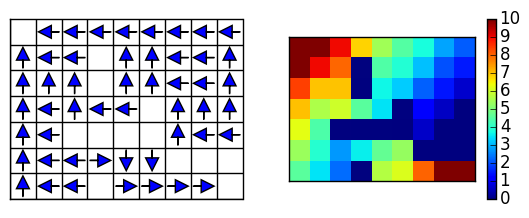

In [136]:
policy_evaluation!(maze, policy, state_reward_function, V, C, n, N, T)

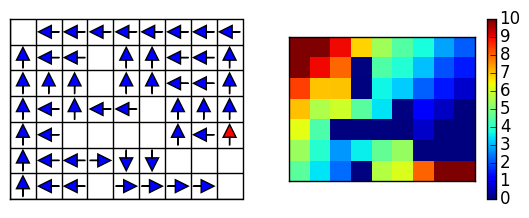

In [137]:
policy_iteration!(maze, policy, V)

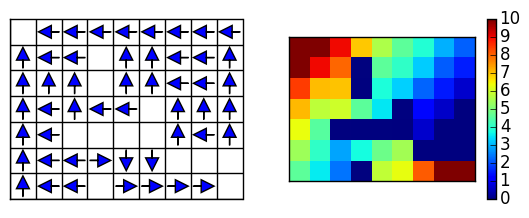

In [138]:
policy_evaluation!(maze, policy, state_reward_function, V, C, n, N, T)

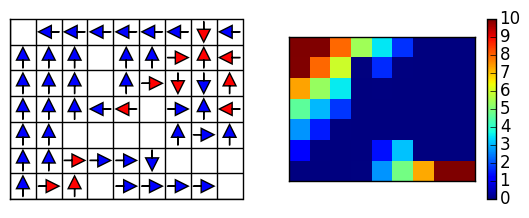

In [115]:
policy_iteration!(maze, policy, V)

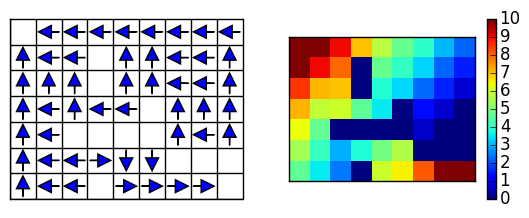

In [139]:
policy_evaluation!(maze, policy, state_reward_function, V, C, n, N, T)